In [14]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import scipy.signal
import uncertainties as uc

import matplotlib

from sklearn.metrics import r2_score

In [15]:
def list_hdf5_files(start_path):
    hdf5_files = []
    for root, dirs, files in os.walk(start_path):
        for file in files:
            if file.endswith('.hdf5'):
                hdf5_files.append(os.path.join(root, file))
    return hdf5_files

def moving_average(data, window_size):   
    extended_data = np.concatenate([data, data[:window_size-1]])  # Extend the data for wrapping
    return np.convolve(extended_data, np.ones(window_size), 'valid')[:len(data)] / window_size


In [16]:
data_dir = "amplitude sweep"
DATA_ROOT = "data"

path = os.path.join(DATA_ROOT, data_dir)

hdf5_files = list_hdf5_files(path)
hdf5_files

['data\\amplitude sweep\\122006_ResonatorSpectroscopy_qb1\\122006_ResonatorSpectroscopy_qb1.hdf5',
 'data\\amplitude sweep\\134753_ResonatorSpectroscopy_qb1\\134753_ResonatorSpectroscopy_qb1.hdf5',
 'data\\amplitude sweep\\140329_ResonatorSpectroscopy_qb1\\140329_ResonatorSpectroscopy_qb1.hdf5',
 'data\\amplitude sweep\\144107_ResonatorSpectroscopy_qb1\\144107_ResonatorSpectroscopy_qb1.hdf5',
 'data\\amplitude sweep\\150751_ResonatorSpectroscopy_qb1\\150751_ResonatorSpectroscopy_qb1.hdf5']

In [17]:
f = h5py.File(hdf5_files[1])

data = np.array(list(f["Experimental Data"]["Data"]))
freq = np.array(list(f["Experimental Data"]["Experimental Metadata"]["task_list"]["list_idx_0"]["freqs"])) * 1e-9 # in GHz
ro_amp = np.array(list(f["Experimental Data"]["Experimental Metadata"]["task_list"]["list_idx_0"]["ro_amp"])) * 1e3 # in mV

y = np.abs(data[:,2] + 1j * data[:,3])

y = np.reshape(y, (len(ro_amp), len(freq)))
y = np.flipud(y)


In [18]:
smoothed_y = np.zeros_like(y)
for i in range(len(y)):
    smoothed_y[i] = moving_average(y[i], 10)

max_ind = []

for i in smoothed_y:
    max_ind.append(np.argmax(i))

min_index = np.argmin(freq[max_ind])
max_index = np.argmax(freq[max_ind])

In [19]:
freq[0] -freq[3]

-0.000300000000000189

In [20]:
a = uc.ufloat(np.max(freq[max_ind]),(freq[1] - freq[0]) )
b = uc.ufloat(np.min(freq[max_ind]),(freq[1] - freq[0]) )
print(f"{(a-b)*1000:L}")
print(f"{a:L}")
print(f"{b:L}")

7.70 \pm 0.14
6.63090 \pm 0.00010
6.62320 \pm 0.00010


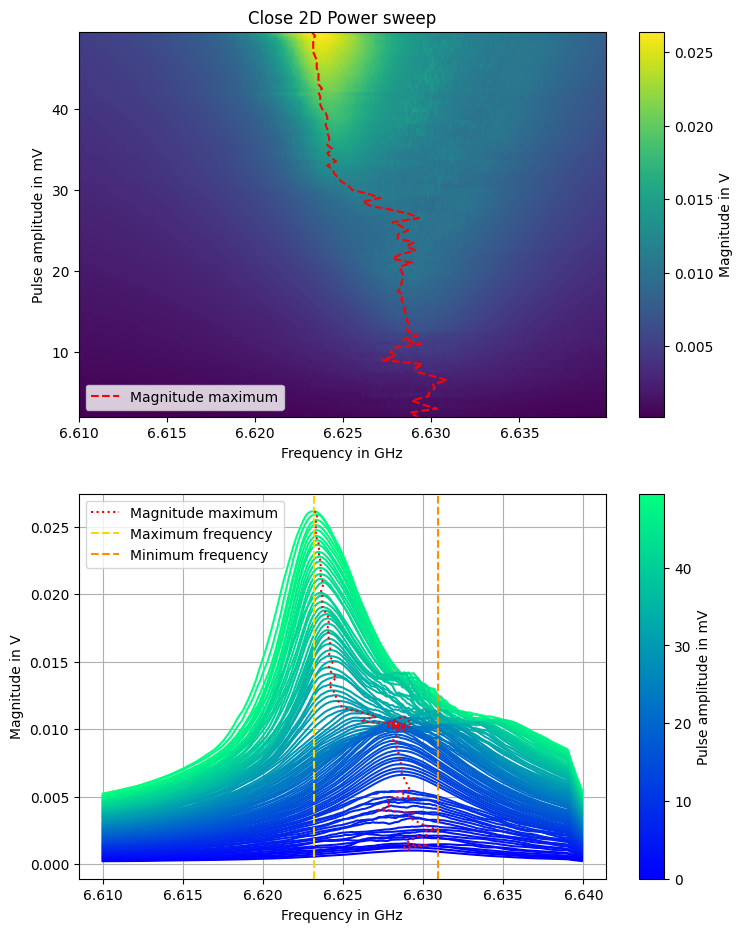

In [21]:
plt.figure(figsize=(8.5, 11))
plt.subplot(211)
plt.title("Close 2D Power sweep")
im = plt.imshow(y, aspect='auto', extent=[np.min(freq), np.max(freq), np.min(ro_amp), np.max(ro_amp)])
bar = plt.colorbar(im, aspect=15)
bar.set_label("Magnitude in V")
plt.xlabel("Frequency in GHz")
plt.ylabel("Pulse amplitude in mV")
plt.plot(freq[max_ind], ro_amp[::-1], color="red", linestyle = "--", label="Magnitude maximum")
plt.legend(loc="lower left")

ax = plt.subplot(212)
colors = matplotlib.colormaps["winter"](np.linspace(0, 1, len(y)))
plt.grid()
plt.xlabel("Frequency in GHz")
plt.ylabel("Magnitude in V")

for d, i in enumerate(smoothed_y):
    plt.plot(freq, i, color=colors[len(colors) - d - 1])

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=matplotlib.colormaps["winter"], norm=plt.Normalize(vmin=0, vmax=np.max(ro_amp)))
# Add colorbar to the second plot
cbar = plt.colorbar(sm, ax=ax, aspect=15)
plt.plot(freq[max_ind], smoothed_y[np.arange(0, smoothed_y.shape[0]),max_ind], color="red", zorder=100, linestyle="dotted", label="Magnitude maximum")
#plt.scatter(freq[max_ind], smoothed_y[np.arange(0, smoothed_y.shape[0]),max_ind], marker=".", color="red", zorder=100)
plt.axvline(freq[max_ind][min_index], color="#ffd500", label=f"Maximum frequency", linestyle="--")
plt.axvline(freq[max_ind][max_index], color="#ff9100", label=f"Minimum frequency", linestyle="--")
plt.legend()
cbar.set_label("Pulse amplitude in mV")
plt.savefig("rsc/narrow_power_sweep.pdf", bbox_inches="tight")

In [22]:
f = h5py.File(hdf5_files[0])

data = np.array(list(f["Experimental Data"]["Data"]))
freq = np.array(list(f["Experimental Data"]["Experimental Metadata"]["task_list"]["list_idx_0"]["freqs"])) * 1e-9 # in GHz
ro_amp = np.array(list(f["Experimental Data"]["Experimental Metadata"]["task_list"]["list_idx_0"]["ro_amp"])) * 1e3 # in mV

y = np.abs(data[:,2] + 1j * data[:,3])

y = np.reshape(y, (len(ro_amp), len(freq)))
y = np.flipud(y)


In [23]:
ro_amp[-1]

248.0

In [24]:
smoothed_y = np.zeros_like(y)
for i in range(len(y)):
    smoothed_y[i] = moving_average(y[i], 2)

max_ind = []

for i in smoothed_y:
    max_ind.append(np.argmax(i))

min_index = np.argmin(freq[max_ind])
max_index = np.argmax(freq[max_ind])

In [27]:
a = uc.ufloat(np.max(freq[max_ind]),(freq[1] - freq[0]) )
b = uc.ufloat(np.min(freq[max_ind]),(freq[1] - freq[0]) )
print(f"{(a-b)*1000:L}")

7.5 \pm 0.7


: 

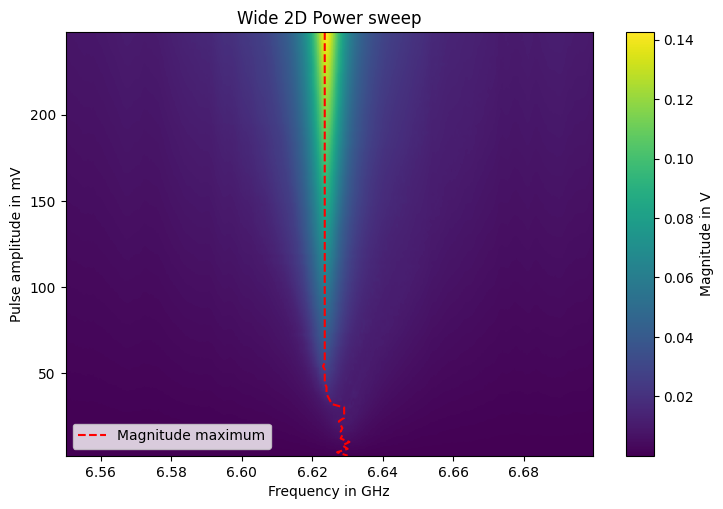

In [26]:
plt.figure(figsize=(8.5, 11/2))
plt.title("Wide 2D Power sweep")
im = plt.imshow(y, aspect='auto', extent=[np.min(freq), np.max(freq), np.min(ro_amp), np.max(ro_amp)])
bar = plt.colorbar(im, aspect=15)
bar.set_label("Magnitude in V")
plt.xlabel("Frequency in GHz")
plt.ylabel("Pulse amplitude in mV")
plt.plot(freq[max_ind], ro_amp[::-1], color="red", linestyle = "--", label="Magnitude maximum")
plt.legend(loc="lower left")

plt.savefig("rsc/wide_power_sweep.pdf", bbox_inches="tight")